## MVP Know Your Transaction (KYT) - Transaction Risk Classification Engine

### Project Overview

This notebook presents a comprehensive implementation of a Transaction Risk Classification Engine for Anti-Money Laundering (AML) compliance in cryptocurrency transactions. The project addresses the critical need for risk assessment of Bitcoin transactions by combining traditional AML indicators with blockchain-specific risk factors.

### Domain Context: Financial AML for Transactions

#### Core Domain Definition
Anti-Money Laundering (AML) for transactions encompasses the comprehensive framework of laws, regulations, procedures, and technological solutions designed to prevent criminals from disguising illegally obtained funds as legitimate income through the global financial system. This domain includes detection, prevention, and reporting of money laundering, terrorist financing, tax evasion, market manipulation, and misuse of public funds.

### Problem Definition: Transaction Risk Classification Engine

#### Problem Statement
Develop a system that assigns risk classifications to cryptocurrency transactions in real-time, integrating traditional AML indicators with blockchain-specific risk factors including wallet clustering, transaction graph analysis, and counterparty reputation scoring.

#### Technical Requirements
- **Problem Type**: Classification 
- **Processing Speed**: Sub-second analysis for high-frequency transactions
- **Difficulty Level**: High - requires complex multi-dimensional data processing
- **Output Format**: Risk binary classification (illicit = 1 /licit = 2)

#### Data Landscape
The system can processes multiple data dimensions:
- Transaction metadata (amounts, timestamps, fees)
- Wallet addresses and clustering information
- Transaction graph relationships and network topology
- Counterparty databases and reputation scores
- Sanctions lists and regulatory databases
- Temporal patterns and behavioral baselines

### References

This notebook implementation is based on the comprehensive research and analysis conducted during the project development phase. The following reference documents were used in the composition of this initial description:

- **Domain Research**: [current-domain.md](domains/current-domain.md) - Contains detailed market analysis, regulatory framework research, and commercial viability assessment for the Financial AML domain;
- **Problem Analysis**: [current-problem.md](problems/current-problem.md) - Provides comprehensive problem refinement, technical requirements analysis, and solution approach evaluation;
- **Dataset Evaluation**: [current-dataset.md](datasets/current-dataset.md) - Documents dataset selection criteria, suitability scoring, and detailed feature analysis for the Elliptic dataset;
- **Dataset Analysis & Preprocessing**: [dataset-analysis-and-preprocessing.ipynb](datasets/scripts/dataset-analysis-and-preprocessing.ipynb) - Comprehensive Jupyter notebook containing Elliptic dataset download, exploratory data analysis, and ML preparation steps;

These reference documents contain the foundational research that informed the technical approach, feature engineering strategy, and implementation decisions reflected in this notebook.

---

This notebook serves as the primary entry point for the MVP KYT implementation and it can run independently, providing both technical implementation and business context for real cryptocurrency transaction risk assessment.

### Import Libraries

Comprehensive installation and import of all required libraries for machine learning procedures.

In [1]:
!pip install azure-storage-blob


from pathlib import Path
from azure.storage.blob import BlobServiceClient


"""
Utility functions for dataset processing and Azure blob storage operations.
"""
class AzureBlobDownloader:
    """
    Azure Blob Storage downloader class for managing dataset downloads.

    This class encapsulates Azure blob operations and maintains connection state
    for efficient dataset management operations.
    """

    def __init__(self, account_url, container_name):
        """
        Initialize Azure blob downloader.

        Args:
            account_url (str): Azure storage account URL
            container_name (str): Name of the blob container

        Raises:
            Exception: If connection to Azure fails or Azure SDK not available
        """
        try:
            self.account_url = account_url
            self.container_name = container_name
            self.blob_service_client = BlobServiceClient(account_url=account_url)
            self.container_client = self.blob_service_client.get_container_client(container_name)

        except Exception as e:
            raise Exception(f"Failed to initialize Azure Blob connection: {e}")


    def download_documents(self, project_folder, document_folder, base_path="../"):
        """
        Download dataset from Azure Blob Storage.

        Args:
            dataset_name: Name of the dataset directory in blob storage
            base_path: Local base path for downloads (default: "../")

        Returns:
            bool: True if download successful, False otherwise
        """
        try:
            original_dir = Path(base_path) / project_folder 
            specific_dir = original_dir / document_folder

            original_dir.mkdir(exist_ok=True)
            specific_dir.mkdir(exist_ok=True)

            remote_path = f"{project_folder}/{document_folder}/"
            downloaded_files = 0

            for blob in self.container_client.list_blobs(name_starts_with=remote_path):
                blob_client = self.container_client.get_blob_client(blob.name)
                local_file_path = Path(base_path) / blob.name
                local_file_path.parent.mkdir(parents=True, exist_ok=True)

                blob_data = blob_client.download_blob()
                with open(local_file_path, "wb") as download_file:
                    download_file.write(blob_data.readall())
                downloaded_files += 1

            print(f"Successfully downloaded {downloaded_files} files from Azure Blob Storage")
            return True

        except Exception as e:
            print(f"Failed to download from Azure Blob Storage: {e}")
            return False

In [2]:
# Gradient Boosting Libraries (install if needed):
# !pip install xgboost lightgbm catboost

# Deep Learning Libraries (install if needed):
# !pip install pytorch-tabnet scikeras tensorflow

import os
import warnings
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import f1_score
import optuna
from optuna.samplers import TPESampler
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix, matthews_corrcoef
from sklearn.metrics import average_precision_score

# Suppress all warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
tf.get_logger().setLevel('ERROR')

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

azureClient = AzureBlobDownloader("https://stmvppos.blob.core.windows.net", "mvpkytsup")

2025-10-27 19:54:12.209238: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Loading pre-processed datasets

Let's load the pre-processed and compressed data from remote and local sources. The dataset is a composition of cryptocurrency transactions in the Bitcoin blockchain. 

It has 166 features, of which 92 features represent local transaction information and another 72 features represent aggregated information from one-hop neighboring transactions (directly linked transactions). Thus, the dataset already has curated information about the relationships between transactions. 

This is very important because money laundering and fraud patterns often involve coordinated transaction clusters and neighborhood patterns.

In [3]:
# Define paths
dataset_dir = Path("elliptic_bitcoin_dataset")
root_dir = Path("./datasets")
processed_dir = root_dir / "processed" / dataset_dir
root_dir.mkdir(exist_ok=True)

# Download processed data from Azure if not present locally
if not processed_dir.exists() or not any(processed_dir.iterdir()):
    print(f"Local processed directory is empty. Downloading from Azure...")
    azureClient.download_documents("datasets/processed", dataset_dir.name, base_path="./")

# The complete dataset already pre-processed 
df_complete = pd.read_hdf(processed_dir / "df_complete.h5", key="df_complete")
print(f"Loaded from HDF5: {df_complete.shape} - All subsequent operations will use compressed data")

# The filtered labeled dataset already pre-processed
df_labeled = pd.read_hdf(processed_dir / "df_labeled.h5", key="df_labeled")
print(f"Loaded from HDF5: {df_labeled.shape} - All subsequent operations will use compressed data")

# The filtered unlabeled dataset already pre-processed
df_unlabeled = pd.read_hdf(processed_dir / "df_unlabeled.h5", key="df_unlabeled")
print(f"Loaded from HDF5: {df_unlabeled.shape} - All subsequent operations will use compressed data")

# The edges dataset that maps relationships between transaction nodes
df_edges = pd.read_hdf(processed_dir / "df_edges.h5", key="df_edges")
print(f"Loaded from HDF5: {df_edges.shape} - All subsequent operations will use compressed data")

# Summary of all datasets
print(f"\n📊 Dataset Summary:")
print(f"  - Features: {df_complete.shape[0]:,} transactions × {df_complete.shape[1] -2} features")
print(f"  - Labeled: {df_labeled.shape[0]:,} transactions")
print(f"  - Unlabeled: {df_unlabeled.shape[0]:,} transactions")
print(f"  - Edges: {df_edges.shape[0]:,} transaction relationships")

Loaded from HDF5: (203769, 168) - All subsequent operations will use compressed data
Loaded from HDF5: (46564, 168) - All subsequent operations will use compressed data
Loaded from HDF5: (157205, 168) - All subsequent operations will use compressed data
Loaded from HDF5: (234355, 2) - All subsequent operations will use compressed data

📊 Dataset Summary:
  - Features: 203,769 transactions × 166 features
  - Labeled: 46,564 transactions
  - Unlabeled: 157,205 transactions
  - Edges: 234,355 transaction relationships


### Machine Learning Strategy

Let's apply machine learning techniques to the labeled dataset portion using supervised learning, and apply the prediction to the unknown unlabeled dataset portion in order to establish a performance baseline for future improvements.

Following these steps:

1. Define overall parameters and make data splits;
2. Define all training models to be used;
3. Define all pipelines to be used during training;
4. Define model parameter distributions for a grid search approach;
5. Define the score function to be used during training;
6. Execute the training;
7. Save all resulting models;
8. Validate all models and select the best models;
9. Use best models to predict unknown data;

**1. Define overall parameters and make data splits**

After splitting the labeled dataset into training and validation (test) sets, let's prepare the training dataset for training and validation using the stratified approach, which generates a fixed number of splits (folds) for the dataset following a fixed proportion of train/test samples. 

The main idea of this approach is to guarantee training without bias toward a specific dataset split because it maintains the same class proportion for each split (fold) generated. We use this technique in labeled and supervised learning, assuming that the dataset's pattern does not have significant changes over time.

In this specific dataset, we consider the timestamp as a grouping factor for transactions but not as a changing factor for the dataset's pattern over time.

In [4]:
# Defining overall parameters
random_seed = 4354 # PARAMETER: random seed
test_size_split = 0.20 # PARAMETER: test set size
n_stratified_splits = 2 # PARAMETER: number of folds
n_pca_components = 0.95 # PARAMETER: PCA components to keep

np.random.seed(random_seed)

# Prepare data
x_labeled = df_labeled.drop(['class', 'txId'], axis=1)
y_labeled = df_labeled['class']

# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(x_labeled, y_labeled,
    test_size=test_size_split, 
    shuffle=True, 
    random_state=random_seed, 
    stratify=y_labeled) # stratified holdout

# Cross-validation setup to be applied in the training set 
cv = StratifiedKFold(n_splits=n_stratified_splits, 
                     shuffle=True, 
                     random_state=random_seed)

**2. Define all training models to be used**

Let's define which models to use during training, selecting diverse ML algorithms covering linear, tree-based, probabilistic, and ensemble methods. 

Different algorithms capture different transaction patterns; ensemble methods reduce overfitting risk and can improve individual model performance.

In [5]:
# Defining the individual models
reg = ('LR', LogisticRegression())
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
nav = ('NB', GaussianNB())
svm = ('SVM', SVC(probability=True))

# Defining ensemble models
bagging = ('Bag', BaggingClassifier())
forest = ('RF', RandomForestClassifier())
extra = ('ET', ExtraTreesClassifier())
ada = ('Ada', AdaBoostClassifier())
gradient = ('GB', GradientBoostingClassifier())

def create_feedforward_nn(hidden_dims=[128, 64], dropout=0.3, learning_rate=0.001, meta=None, input_dim=59):
    """
    Create a feedforward neural network for binary classification.
    
    Args:
        hidden_dims: List of hidden layer sizes
        dropout: Dropout rate for regularization
        learning_rate: Optimizer learning rate
    
    Returns:
        Compiled Keras Sequential model
    """

    # Get actual PCA output dimension (DYNAMIC per CV fold)
    input_dim = meta['n_features_in_'] if meta else 59  # Fallback to 59 if meta unavailable

    model = Sequential()
    
    # Input layer + first hidden layer
    model.add(Dense(hidden_dims[0], activation='relu', input_dim=input_dim))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    # Additional hidden layers
    for units in hidden_dims[1:]:
        model.add(Dense(units, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
    
    # Output layer (binary classification)
    model.add(Dense(2, activation='softmax'))
    
    # Compile with focal loss approximation (class weights)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

**3. Define all pipelines to be used during training**

Let's define which ML pipelines to use during training, by configuring which pre-processing operations and models will be used in the training process. Pipelines also help avoid data leakage by ensuring that feature transformation is applied only to the training dataset portion.          

For feature transformation, the standard scaler was used to ensure the best scale for feature values. By normalizing all values to a common metric, it reduces bias toward feature magnitude and enables subsequent operations to capture important patterns between features without being influenced mainly by their magnitude. All features contribute equally to pattern detection. This is especially important in finance because the difference between feature scales can be significant.

For feature dimensionality reduction, Principal Component Analysis (PCA) was used to reduce from 166 to only 59 features. We aim to reduce feature dimensionality while maximizing the dissimilarity of the original dataset, thus extracting the most discriminative features and improving model training performance. It must be applied after the standard scaler to avoid the mentioned magnitude bias, and should be used in datasets that have a large quantity of features.

In [6]:
# Creating the pipelines
pipelines = []
std  = ('std', StandardScaler())  # Standardization

# Defining the pipelines, for future experimentation 
#pipelines.append(('LR', Pipeline([std, ('pca', PCA(n_components=n_pca_components)), reg])))  
#pipelines.append(('NB', Pipeline([std, ('pca', PCA(n_components=n_pca_components)), nav])))  
#pipelines.append(('KNN', Pipeline([std, ('pca', PCA(n_components=n_pca_components)), knn])))
#pipelines.append(('CART', Pipeline([std, ('pca', PCA(n_components=n_pca_components)), cart])))
#pipelines.append(('SVM', Pipeline([std, ('pca', PCA(n_components=n_pca_components)), svm])))
#pipelines.append(('Bag', Pipeline([std, ('pca', PCA(n_components=n_pca_components)), bagging])))
#pipelines.append(('RF', Pipeline([std, ('pca', PCA(n_components=n_pca_components)), forest])))
#pipelines.append(('ET', Pipeline([std, ('pca', PCA(n_components=n_pca_components)), extra])))
#pipelines.append(('Ada', Pipeline([std, ('pca', PCA(n_components=n_pca_components)), ada])))
#pipelines.append(('GB', Pipeline([std, ('pca', PCA(n_components=n_pca_components)), gradient])))

# ENSEMBLE: SVM + KNN Voting Soft
voting_soft = ('Vote-Soft', Pipeline([
    std, 
    ('pca', PCA(n_components=n_pca_components)),
    ('voting', VotingClassifier(
        estimators=[
            ('svm', SVC(probability=True)),  # Enable probability for soft voting
            ('knn', KNeighborsClassifier())
        ],
        voting='soft',
        weights=[0.6, 0.4]  # Weight SVM higher (better performer)
    ))
]))

# ENSEMBLE: SVM + KNN Voting Hard
voting_hard = ('Vote-Hard', Pipeline([
    std,
    ('pca', PCA(n_components=n_pca_components)),
    ('voting', VotingClassifier(
        estimators=[
            ('svm', SVC()),
            ('knn', KNeighborsClassifier())
        ],
        voting='hard'
    ))
]))

# ENSEMBLE: SVM + KNN Stacking
stacking = ('Stack', Pipeline([
    std,
    ('pca', PCA(n_components=n_pca_components)),
    ('stacking', StackingClassifier(
        estimators=[
            ('svm', SVC(probability=True)),
            ('knn', KNeighborsClassifier())
        ],
        final_estimator=LogisticRegression(),  # Meta-learner
        cv=5,
        passthrough=False  # Only use base predictions, not original features
    ))
]))

#pipelines.append(voting_soft)
#pipelines.append(voting_hard)
#pipelines.append(stacking)

# ENSEMBLE: Bagging with SVM base estimator
bag_svm = ('Bag-SVM', Pipeline([
    std,
    ('pca', PCA(n_components=n_pca_components)),
    ('bagging', BaggingClassifier(
        estimator=SVC(probability=True),
        n_estimators=10,
        max_samples=0.8,
        max_features=0.8,
        bootstrap=True,
        random_state=random_seed
    ))
]))

# ENSEMBLE: Bagging with KNN base estimator
bag_knn = ('Bag-KNN', Pipeline([
    std,
    ('pca', PCA(n_components=n_pca_components)),
    ('bagging', BaggingClassifier(
        estimator=KNeighborsClassifier(),
        n_estimators=10,
        max_samples=0.8,
        max_features=0.8,
        bootstrap=True,
        random_state=random_seed
    ))
]))


#pipelines.append(bag_svm)
#pipelines.append(bag_knn)

# XGBoost: Extreme Gradient Boosting
xgboost = ('XGB', Pipeline([
    std,
    ('pca', PCA(n_components=n_pca_components)),
    ('xgb', xgb.XGBClassifier(
        n_estimators=500,
        max_depth=7,
        learning_rate=0.1,
        scale_pos_weight=9.25,  # For 9:1 class imbalance
        tree_method='hist',
        random_state=random_seed,
        verbosity=0
    ))
]))

#pipelines.append(xgboost)

# LightGBM: Light Gradient Boosting Machine
lightgbm = ('LGB', Pipeline([
    std,
    ('pca', PCA(n_components=n_pca_components)),
    ('lgb', lgb.LGBMClassifier(
        n_estimators=500,
        num_leaves=127,
        max_depth=7,
        learning_rate=0.1,
        class_weight='balanced',  # For class imbalance
        random_state=random_seed,
        verbose=-1
    ))
]))

#pipelines.append(lightgbm)

# CatBoost: Categorical Boosting
catboost = ('CAT', Pipeline([
    std,
    ('pca', PCA(n_components=n_pca_components)),
    ('cat', cb.CatBoostClassifier(
        iterations=500,
        depth=8,
        learning_rate=0.1,
        auto_class_weights='Balanced',  # For class imbalance
        random_seed=random_seed,
        verbose=False
    ))
]))

#pipelines.append(catboost)

# TabNet: Attention-based deep learning for tabular data
tabnet = ('TabNet', Pipeline([
    ('quantile', QuantileTransformer(n_quantiles=100, output_distribution='normal')),
    ('tabnet', TabNetClassifier(
        n_d=64,
        n_a=64,
        n_steps=5,
        gamma=1.5,
        lambda_sparse=1e-4,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=0.02),
        scheduler_params={"step_size": 50, "gamma": 0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        mask_type='sparsemax',
        verbose=0,
        seed=random_seed
    ))
]))

#pipelines.append(tabnet)


# Feedforward NN: Deep neural network with batch normalization
feedforward_nn = ('FNN', Pipeline([
    std,
    ('pca', PCA(n_components=n_pca_components)),
    ('fnn', KerasClassifier(
        model=create_feedforward_nn,
        input_dim=59,  # Post-PCA dimension
        hidden_dims=[128, 64],
        dropout=0.3,
        learning_rate=0.001,
        epochs=100,
        batch_size=256,
        verbose=0
    ))
]))

pipelines.append(feedforward_nn)

**4. Define model parameter distributions for a grid search approach**

Let's prepare the parameter distributions for a random grid search, by using a distribution of possible parameter values, so that the training phase can explore the best performance models also from the perspective of their hyperparameters. This is a better solution than the common grid search approach because it can explore a broader hyperparameter space and is often faster. 

Three types of parameter distributions were used:

- uniform: Continuous values with equal probability across a range, used when all values in the range are equally valid;
- loguniform: Continuous values on logarithmic scale (exponential distribution), used when smaller values are often better;
- randint: Discrete integer values with equal probability, used for discrete hyperparameters.

In [7]:
# Define parameter distributions using Optuna trial lambdas
# Enhanced with comprehensive documentation
# Optimized for financial/cryptocurrency transaction risk classification

# Note: KerasClassifier (scikeras) and TabNetClassifier automatically handle label encoding
# String labels ('1', '2') are converted to integers (0, 1) internally

param_distributions = {
    'LR': {
        'pca__n_components': lambda trial: trial.suggest_float('pca__n_components', 0.90, 0.99),
        'pca__whiten': lambda trial: trial.suggest_categorical('pca__whiten', [True, False]),
        'pca__svd_solver': lambda trial: trial.suggest_categorical('pca__svd_solver', ['auto', 'full']),
        'LR__C': lambda trial: trial.suggest_float('LR__C', 1e-4, 1e2, log=True),
        'LR__solver': lambda trial: trial.suggest_categorical('LR__solver', ['lbfgs', 'newton-cg', 'sag', 'saga']),
        'LR__penalty': lambda trial: trial.suggest_categorical('LR__penalty', ['l2', None]),
        'LR__max_iter': lambda trial: trial.suggest_categorical('LR__max_iter', [1000, 2000, 5000]),
        'LR__tol': lambda trial: trial.suggest_float('LR__tol', 1e-6, 1e-3, log=True)
    },

    'KNN': {
        'pca__n_components': lambda trial: trial.suggest_float('pca__n_components', 0.90, 0.99),
        'pca__whiten': lambda trial: trial.suggest_categorical('pca__whiten', [True, False]),
        'pca__svd_solver': lambda trial: trial.suggest_categorical('pca__svd_solver', ['auto', 'full']),
        'KNN__n_neighbors': lambda trial: trial.suggest_int('KNN__n_neighbors', 3, 20),
        'KNN__weights': lambda trial: trial.suggest_categorical('KNN__weights', ['uniform', 'distance']),
        'KNN__metric': lambda trial: trial.suggest_categorical('KNN__metric', ['euclidean', 'manhattan', 'minkowski']),
        'KNN__p': lambda trial: trial.suggest_int('KNN__p', 1, 2)
    },

    'CART': {
        'pca__n_components': lambda trial: trial.suggest_float('pca__n_components', 0.90, 0.99),
        'pca__whiten': lambda trial: trial.suggest_categorical('pca__whiten', [True, False]),
        'pca__svd_solver': lambda trial: trial.suggest_categorical('pca__svd_solver', ['auto', 'full']),
        'CART__max_depth': lambda trial: trial.suggest_int('CART__max_depth', 3, 19),
        'CART__min_samples_split': lambda trial: trial.suggest_int('CART__min_samples_split', 10, 49),
        'CART__min_samples_leaf': lambda trial: trial.suggest_int('CART__min_samples_leaf', 5, 19),
        'CART__criterion': lambda trial: trial.suggest_categorical('CART__criterion', ['gini', 'entropy'])
    },

    'NB': {
        'pca__n_components': lambda trial: trial.suggest_float('pca__n_components', 0.90, 0.99),
        'pca__whiten': lambda trial: trial.suggest_categorical('pca__whiten', [True, False]),
        'pca__svd_solver': lambda trial: trial.suggest_categorical('pca__svd_solver', ['auto', 'full']),
        'NB__var_smoothing': lambda trial: trial.suggest_float('NB__var_smoothing', 1e-12, 1e-6, log=True),
        'NB__priors': lambda trial: trial.suggest_categorical('NB__priors', [None])
    },

    'SVM': {
        'pca__n_components': lambda trial: trial.suggest_float('pca__n_components', 0.90, 0.99),
        'pca__whiten': lambda trial: trial.suggest_categorical('pca__whiten', [True, False]),
        'pca__svd_solver': lambda trial: trial.suggest_categorical('pca__svd_solver', ['auto', 'full']),
        'SVM__C': lambda trial: trial.suggest_float('SVM__C', 1e-2, 1e3, log=True),
        'SVM__kernel': lambda trial: trial.suggest_categorical('SVM__kernel', ['rbf', 'poly', 'sigmoid']),
        'SVM__gamma': lambda trial: trial.suggest_categorical('SVM__gamma', ['scale', 'auto'])
    },

    'RF': {
        'pca__n_components': lambda trial: trial.suggest_float('pca__n_components', 0.90, 0.99),
        'pca__whiten': lambda trial: trial.suggest_categorical('pca__whiten', [True, False]),
        'pca__svd_solver': lambda trial: trial.suggest_categorical('pca__svd_solver', ['auto', 'full']),
        'RF__n_estimators': lambda trial: trial.suggest_int('RF__n_estimators', 100, 499),
        'RF__max_depth': lambda trial: trial.suggest_int('RF__max_depth', 10, 24),
        'RF__min_samples_split': lambda trial: trial.suggest_int('RF__min_samples_split', 5, 19),
        'RF__min_samples_leaf': lambda trial: trial.suggest_int('RF__min_samples_leaf', 2, 9),
        'RF__max_features': lambda trial: trial.suggest_categorical('RF__max_features', ['sqrt', 'log2', None]),
        'RF__bootstrap': lambda trial: trial.suggest_categorical('RF__bootstrap', [True, False])
    },

    'ET': {
        'pca__n_components': lambda trial: trial.suggest_float('pca__n_components', 0.90, 0.99),
        'pca__whiten': lambda trial: trial.suggest_categorical('pca__whiten', [True, False]),
        'pca__svd_solver': lambda trial: trial.suggest_categorical('pca__svd_solver', ['auto', 'full']),
        'ET__n_estimators': lambda trial: trial.suggest_int('ET__n_estimators', 100, 499),
        'ET__max_depth': lambda trial: trial.suggest_int('ET__max_depth', 10, 24),
        'ET__min_samples_split': lambda trial: trial.suggest_int('ET__min_samples_split', 5, 19),
        'ET__min_samples_leaf': lambda trial: trial.suggest_int('ET__min_samples_leaf', 2, 9),
        'ET__max_features': lambda trial: trial.suggest_categorical('ET__max_features', ['sqrt', 'log2', None]),
        'ET__bootstrap': lambda trial: trial.suggest_categorical('ET__bootstrap', [True, False])
    },

    'GB': {
        'pca__n_components': lambda trial: trial.suggest_float('pca__n_components', 0.90, 0.99),
        'pca__whiten': lambda trial: trial.suggest_categorical('pca__whiten', [True, False]),
        'pca__svd_solver': lambda trial: trial.suggest_categorical('pca__svd_solver', ['auto', 'full']),
        'GB__n_estimators': lambda trial: trial.suggest_int('GB__n_estimators', 100, 299),
        'GB__learning_rate': lambda trial: trial.suggest_float('GB__learning_rate', 1e-2, 3e-1, log=True),
        'GB__max_depth': lambda trial: trial.suggest_int('GB__max_depth', 3, 7),
        'GB__subsample': lambda trial: trial.suggest_float('GB__subsample', 0.7, 0.9)
    },

    'Ada': {
        'pca__n_components': lambda trial: trial.suggest_float('pca__n_components', 0.90, 0.99),
        'pca__whiten': lambda trial: trial.suggest_categorical('pca__whiten', [True, False]),
        'pca__svd_solver': lambda trial: trial.suggest_categorical('pca__svd_solver', ['auto', 'full']),
        'Ada__n_estimators': lambda trial: trial.suggest_int('Ada__n_estimators', 50, 199),
        'Ada__learning_rate': lambda trial: trial.suggest_float('Ada__learning_rate', 0.5, 1.5),
        'Ada__algorithm': lambda trial: trial.suggest_categorical('Ada__algorithm', ['SAMME'])
    },

    'Bag': {
        'pca__n_components': lambda trial: trial.suggest_float('pca__n_components', 0.90, 0.99),
        'pca__whiten': lambda trial: trial.suggest_categorical('pca__whiten', [True, False]),
        'pca__svd_solver': lambda trial: trial.suggest_categorical('pca__svd_solver', ['auto', 'full']),
        'Bag__n_estimators': lambda trial: trial.suggest_int('Bag__n_estimators', 50, 199),
        'Bag__max_samples': lambda trial: trial.suggest_float('Bag__max_samples', 0.6, 0.9),
        'Bag__max_features': lambda trial: trial.suggest_float('Bag__max_features', 0.7, 1.0)
    },
    
    'Vote-Soft': {
        'pca__n_components': lambda trial: trial.suggest_float('pca__n_components', 0.90, 0.99),
        'pca__whiten': lambda trial: trial.suggest_categorical('pca__whiten', [True, False]),
        'pca__svd_solver': lambda trial: trial.suggest_categorical('pca__svd_solver', ['auto', 'full']),
        'voting__svm__C': lambda trial: trial.suggest_float('voting__svm__C', 1e-2, 1e3, log=True),
        'voting__svm__kernel': lambda trial: trial.suggest_categorical('voting__svm__kernel', ['rbf', 'poly']),
        'voting__svm__gamma': lambda trial: trial.suggest_categorical('voting__svm__gamma', ['scale', 'auto']),
        'voting__knn__n_neighbors': lambda trial: trial.suggest_int('voting__knn__n_neighbors', 3, 20),
        'voting__knn__weights': lambda trial: trial.suggest_categorical('voting__knn__weights', ['uniform', 'distance']),
        'voting__knn__metric': lambda trial: trial.suggest_categorical('voting__knn__metric', ['euclidean', 'manhattan']),
        'voting__weights': lambda trial: trial.suggest_categorical('voting__weights', [[0.7, 0.3], [0.6, 0.4], [0.5, 0.5], [0.8, 0.2]])
    },
    
    'Vote-Hard': {
        'pca__n_components': lambda trial: trial.suggest_float('pca__n_components', 0.90, 0.99),
        'pca__whiten': lambda trial: trial.suggest_categorical('pca__whiten', [True, False]),
        'pca__svd_solver': lambda trial: trial.suggest_categorical('pca__svd_solver', ['auto', 'full']),
        'voting__svm__C': lambda trial: trial.suggest_float('voting__svm__C', 1e-2, 1e3, log=True),
        'voting__svm__kernel': lambda trial: trial.suggest_categorical('voting__svm__kernel', ['rbf', 'poly']),
        'voting__svm__gamma': lambda trial: trial.suggest_categorical('voting__svm__gamma', ['scale', 'auto']),
        'voting__knn__n_neighbors': lambda trial: trial.suggest_int('voting__knn__n_neighbors', 3, 20),
        'voting__knn__weights': lambda trial: trial.suggest_categorical('voting__knn__weights', ['uniform', 'distance']),
        'voting__knn__metric': lambda trial: trial.suggest_categorical('voting__knn__metric', ['euclidean', 'manhattan'])
    },
    
    'Stack': {
        'pca__n_components': lambda trial: trial.suggest_float('pca__n_components', 0.90, 0.99),
        'pca__whiten': lambda trial: trial.suggest_categorical('pca__whiten', [True, False]),
        'pca__svd_solver': lambda trial: trial.suggest_categorical('pca__svd_solver', ['auto', 'full']),
        'stacking__svm__C': lambda trial: trial.suggest_float('stacking__svm__C', 1e-2, 1e3, log=True),
        'stacking__svm__kernel': lambda trial: trial.suggest_categorical('stacking__svm__kernel', ['rbf', 'poly']),
        'stacking__svm__gamma': lambda trial: trial.suggest_categorical('stacking__svm__gamma', ['scale', 'auto']),
        'stacking__knn__n_neighbors': lambda trial: trial.suggest_int('stacking__knn__n_neighbors', 3, 20),
        'stacking__knn__weights': lambda trial: trial.suggest_categorical('stacking__knn__weights', ['uniform', 'distance']),
        'stacking__knn__metric': lambda trial: trial.suggest_categorical('stacking__knn__metric', ['euclidean', 'manhattan']),
        'stacking__final_estimator__C': lambda trial: trial.suggest_float('stacking__final_estimator__C', 1e-4, 1e2, log=True),
        'stacking__final_estimator__solver': lambda trial: trial.suggest_categorical('stacking__final_estimator__solver', ['lbfgs', 'saga']),
        'stacking__final_estimator__max_iter': lambda trial: trial.suggest_categorical('stacking__final_estimator__max_iter', [1000, 2000])
    },
    
    'Bag-SVM': {
        'pca__n_components': lambda trial: trial.suggest_float('pca__n_components', 0.90, 0.99),
        'pca__whiten': lambda trial: trial.suggest_categorical('pca__whiten', [True, False]),
        'pca__svd_solver': lambda trial: trial.suggest_categorical('pca__svd_solver', ['auto', 'full']),
        'bagging__estimator__C': lambda trial: trial.suggest_float('bagging__estimator__C', 1e-2, 1e3, log=True),
        'bagging__estimator__kernel': lambda trial: trial.suggest_categorical('bagging__estimator__kernel', ['rbf', 'poly', 'linear']),
        'bagging__estimator__gamma': lambda trial: trial.suggest_categorical('bagging__estimator__gamma', ['scale', 'auto']),
        'bagging__n_estimators': lambda trial: trial.suggest_int('bagging__n_estimators', 10, 99),
        'bagging__max_samples': lambda trial: trial.suggest_float('bagging__max_samples', 0.5, 0.9),
        'bagging__max_features': lambda trial: trial.suggest_float('bagging__max_features', 0.5, 0.9),
        'bagging__bootstrap': lambda trial: trial.suggest_categorical('bagging__bootstrap', [True, False])
    },
    
    'Bag-KNN': {
        'pca__n_components': lambda trial: trial.suggest_float('pca__n_components', 0.90, 0.99),
        'pca__whiten': lambda trial: trial.suggest_categorical('pca__whiten', [True, False]),
        'pca__svd_solver': lambda trial: trial.suggest_categorical('pca__svd_solver', ['auto', 'full']),
        'bagging__estimator__n_neighbors': lambda trial: trial.suggest_int('bagging__estimator__n_neighbors', 3, 20),
        'bagging__estimator__weights': lambda trial: trial.suggest_categorical('bagging__estimator__weights', ['uniform', 'distance']),
        'bagging__estimator__metric': lambda trial: trial.suggest_categorical('bagging__estimator__metric', ['euclidean', 'manhattan', 'minkowski']),
        'bagging__n_estimators': lambda trial: trial.suggest_int('bagging__n_estimators', 10, 99),
        'bagging__max_samples': lambda trial: trial.suggest_float('bagging__max_samples', 0.5, 0.9),
        'bagging__max_features': lambda trial: trial.suggest_float('bagging__max_features', 0.5, 0.9),
        'bagging__bootstrap': lambda trial: trial.suggest_categorical('bagging__bootstrap', [True, False])
    },

    'XGB': {
        'pca__n_components': lambda trial: trial.suggest_float('pca__n_components', 0.90, 0.99),
        'pca__whiten': lambda trial: trial.suggest_categorical('pca__whiten', [True, False]),
        'pca__svd_solver': lambda trial: trial.suggest_categorical('pca__svd_solver', ['auto', 'full']),
        'xgb__n_estimators': lambda trial: trial.suggest_int('xgb__n_estimators', 100, 1000),
        'xgb__max_depth': lambda trial: trial.suggest_int('xgb__max_depth', 3, 9),
        'xgb__learning_rate': lambda trial: trial.suggest_float('xgb__learning_rate', 0.01, 0.3, log=True),
        'xgb__min_child_weight': lambda trial: trial.suggest_int('xgb__min_child_weight', 1, 7),
        'xgb__gamma': lambda trial: trial.suggest_float('xgb__gamma', 0, 0.5),
        'xgb__subsample': lambda trial: trial.suggest_float('xgb__subsample', 0.6, 1.0),
        'xgb__colsample_bytree': lambda trial: trial.suggest_float('xgb__colsample_bytree', 0.6, 1.0),
        'xgb__scale_pos_weight': lambda trial: trial.suggest_float('xgb__scale_pos_weight', 1, 20),
        'xgb__reg_alpha': lambda trial: trial.suggest_float('xgb__reg_alpha', 0, 10),
        'xgb__reg_lambda': lambda trial: trial.suggest_float('xgb__reg_lambda', 1, 100)
    },

    'LGB': {
        'pca__n_components': lambda trial: trial.suggest_float('pca__n_components', 0.90, 0.99),
        'pca__whiten': lambda trial: trial.suggest_categorical('pca__whiten', [True, False]),
        'pca__svd_solver': lambda trial: trial.suggest_categorical('pca__svd_solver', ['auto', 'full']),
        'lgb__n_estimators': lambda trial: trial.suggest_int('lgb__n_estimators', 100, 1000),
        'lgb__num_leaves': lambda trial: trial.suggest_int('lgb__num_leaves', 31, 255),
        'lgb__max_depth': lambda trial: trial.suggest_int('lgb__max_depth', 3, 9),
        'lgb__learning_rate': lambda trial: trial.suggest_float('lgb__learning_rate', 0.01, 0.3, log=True),
        'lgb__min_child_samples': lambda trial: trial.suggest_int('lgb__min_child_samples', 5, 30),
        'lgb__subsample': lambda trial: trial.suggest_float('lgb__subsample', 0.6, 1.0),
        'lgb__colsample_bytree': lambda trial: trial.suggest_float('lgb__colsample_bytree', 0.6, 1.0),
        'lgb__reg_alpha': lambda trial: trial.suggest_float('lgb__reg_alpha', 0, 1),
        'lgb__reg_lambda': lambda trial: trial.suggest_float('lgb__reg_lambda', 0, 1)
    },

    'CAT': {
        'pca__n_components': lambda trial: trial.suggest_float('pca__n_components', 0.90, 0.99),
        'pca__whiten': lambda trial: trial.suggest_categorical('pca__whiten', [True, False]),
        'pca__svd_solver': lambda trial: trial.suggest_categorical('pca__svd_solver', ['auto', 'full']),
        'cat__iterations': lambda trial: trial.suggest_int('cat__iterations', 100, 1000),
        'cat__depth': lambda trial: trial.suggest_int('cat__depth', 4, 10),
        'cat__learning_rate': lambda trial: trial.suggest_float('cat__learning_rate', 0.01, 0.3, log=True),
        'cat__l2_leaf_reg': lambda trial: trial.suggest_int('cat__l2_leaf_reg', 1, 9),
        'cat__border_count': lambda trial: trial.suggest_categorical('cat__border_count', [32, 64, 128, 255]),
        'cat__bagging_temperature': lambda trial: trial.suggest_float('cat__bagging_temperature', 0, 1),
        'cat__random_strength': lambda trial: trial.suggest_float('cat__random_strength', 0, 2)
    },
    
    'TabNet': {
        # TabNet-specific hyperparameters
        'tabnet__n_d': lambda trial: trial.suggest_categorical('tabnet__n_d', [8, 16, 32, 64]),
        'tabnet__n_a': lambda trial: trial.suggest_categorical('tabnet__n_a', [8, 16, 32, 64]),
        'tabnet__n_steps': lambda trial: trial.suggest_int('tabnet__n_steps', 3, 7),
        'tabnet__gamma': lambda trial: trial.suggest_float('tabnet__gamma', 1.0, 2.0),
        'tabnet__lambda_sparse': lambda trial: trial.suggest_float('tabnet__lambda_sparse', 1e-6, 1e-3, log=True),
        'tabnet__mask_type': lambda trial: trial.suggest_categorical('tabnet__mask_type', ['sparsemax', 'entmax']),
    },

    'FNN': {
        # PCA hyperparameters
        'pca__n_components': lambda trial: trial.suggest_float('pca__n_components', 0.90, 0.99),
        'pca__whiten': lambda trial: trial.suggest_categorical('pca__whiten', [True, False]),
        'pca__svd_solver': lambda trial: trial.suggest_categorical('pca__svd_solver', ['auto', 'full']),
        # Neural network architecture
        'fnn__hidden_dims': lambda trial: trial.suggest_categorical(
            'fnn__hidden_dims',
            [[128, 64], [256, 128], [512, 256, 128], [128, 64, 32]]
        ),
        # Regularization
        'fnn__dropout': lambda trial: trial.suggest_float('fnn__dropout', 0.1, 0.5),
        # Optimizer
        'fnn__learning_rate': lambda trial: trial.suggest_float('fnn__learning_rate', 1e-4, 1e-2, log=True),
        # Training
        'fnn__epochs': lambda trial: trial.suggest_int('fnn__epochs', 50, 200),
        'fnn__batch_size': lambda trial: trial.suggest_categorical('fnn__batch_size', [128, 256, 512])
    }
}

**5. Define the score function and the objective function to be used during training**

Let's define the score function that will be used to measure each model's performance. Instead of using just one metric alone, the function enables us to define a weighted multi-metric approach, defining which metrics would be more important for the model's performance. The chosen score is a combination of three important metrics: 

- Recall measures how good the model is at not having false negatives;
- Precision measures how good the model is at not having false positives;  
- Accuracy measures how good the model is at not having false classifications;

In financial transaction risk assessments, it is more important to have fewer false negatives than false positive classifications, because it would be less risky to block a transaction wrongly considered illicit than to not block a transaction wrongly considered licit.

In [8]:
def create_objective(model_name, pipeline, param_dist, X_train, y_train, cv, scorer):
    """Create Optuna objective function for hyperparameter optimization"""
    def objective(trial):
        # Get parameter suggestions by calling lambdas with trial
        params = {}
        for param_name, suggest_fn in param_dist[model_name].items():
            params[param_name] = suggest_fn(trial)
        
        # Set pipeline parameters
        pipeline.set_params(**params)
        
        # Perform cross-validation
        scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=scorer, n_jobs=1)
        
        # Return mean score
        return scores.mean()
    
    return objective


def aml_score(y_true, y_pred):
    """
    Competition-grade metric for imbalanced fraud detection.
    
    Combines:
    - MCC (Matthews Correlation Coefficient): Handles class imbalance
    - Cost-sensitive scoring: Explicitly penalizes false positives
    
    Args:
        y_true: True labels (0=licit, 1=illicit)
        y_pred: Predicted labels (0=licit, 1=illicit)
    
    Returns:
        float: Composite score (0-1 range, higher is better)
    """
    # MCC: Handles imbalance naturally
    mcc = matthews_corrcoef(y_true, y_pred)
    
    # Cost-sensitive component
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Business costs (adjust based on regulatory requirements)
    cost_fp = 1    # Cost of blocking legitimate transaction (your priority!)
    cost_fn = 10   # Cost of missing illicit transaction (regulatory risk)
    
    total_cost = (fp * cost_fp) + (fn * cost_fn)
    max_cost = len(y_true) * cost_fn
    cost_score = 1 - (total_cost / max_cost)
    
    # Weighted combination: 60% MCC + 40% cost minimization
    return 0.4 * mcc + 0.6 * cost_score

# Update scorer
composite_scorer = make_scorer(aml_score)

**6. Execute the training** [CAN BE SKIPPED ~ 2h]

Let's execute the training phase using random grid search and execute it in parallel, with cross-validation of all dataset splits (folds) and rank the best models by score function.

The final plot will display all model training samples with their mean and variance performance during training.

🔍 Training Models with Optuna Bayesian Optimization...
Training 1 models with 2 trials each
------------------------------------------------------------
Training FNN... 

I0000 00:00:1761605654.687362  156735 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3066 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5
2025-10-27 19:54:16.280711: I external/local_xla/xla/service/service.cc:163] XLA service 0x766d1c003720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-27 19:54:16.280723: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-10-27 19:54:16.310856: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-27 19:54:16.496394: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
I0000 00:00:1761605658.034090  156843 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at mos

✅ 0.9497 (±0.0014)


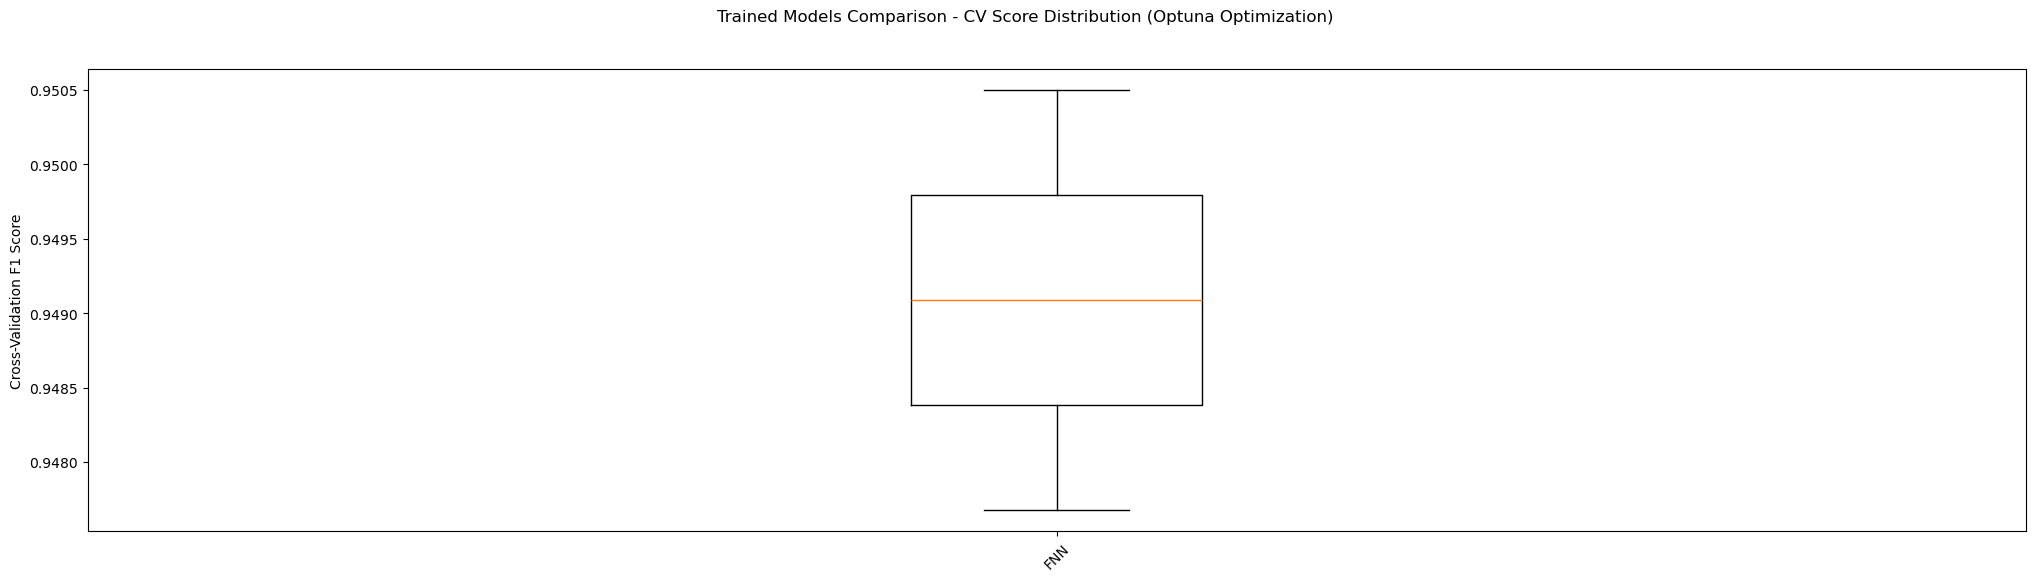

In [9]:
# Training parameters
n_trials = 2  # PARAMETER: Number of Optuna trials per model
n_jobs = 1    # PARAMETER: Use all available cores

# Filter to train only basic models (first 10)
basic_pipelines = pipelines[:10]

# Create result collections
training_models = []
cv_results_all = []  # Store all CV scores for boxplot
study_results = {}   # Store Optuna studies for analysis

print("🔍 Training Models with Optuna Bayesian Optimization...")
print(f"Training {len(basic_pipelines)} models with {n_trials} trials each")
print("-" * 60)

for name, pipe in basic_pipelines:
    print(f"Training {name}...", end=" ", flush=True)
    
    # Create Optuna study with TPE sampler
    study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=random_seed)
    )
    
    # Create objective function
    objective = create_objective(
        model_name=name,
        pipeline=pipe,
        param_dist=param_distributions,
        X_train=X_train,
        y_train=y_train,
        cv=cv,
        scorer=composite_scorer
    )
    
    # Optimize
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    
    # Extract best parameters and set them
    best_params = study.best_params
    pipe.set_params(**best_params)
    
    # Get CV scores for evaluation (doesn't fit the original pipe!)
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring=composite_scorer, n_jobs=n_jobs)
    cv_results_all.append(cv_scores)
    
    # Explicitly fit pipeline on full training set to avoid NotFittedError
    pipe.fit(X_train, y_train)
    
    best_score = study.best_value
    std_score = cv_scores.std()
    
    print(f"✅ {best_score:.4f} (±{std_score:.4f})")
    
    training_models.append((name, pipe))
    study_results[name] = study

# Create boxplot with individual CV fold scores
fig = plt.figure(figsize=(25,6))
fig.suptitle('Trained Models Comparison - CV Score Distribution (Optuna Optimization)') 
ax = fig.add_subplot(111) 
plt.boxplot(cv_results_all, labels=[name for name, _ in training_models])
ax.set_ylabel('Cross-Validation F1 Score')
ax.tick_params(axis='x', rotation=45)
plt.show()

optimized_models = training_models.copy()

**Optuna Optimization Analysis**

Visualize Optuna optimization history and parameter importance for each model.

In [10]:
# Visualize Optuna optimization for top 3 models
top_models = sorted(training_models, key=lambda x: study_results[x[0]].best_value, reverse=True)[:3]

print("📊 Optuna Optimization Analysis for Top 3 Models")
print("-" * 60)

for name, _ in top_models:
    study = study_results[name]
    print(f"\n{name} - Best Score: {study.best_value:.4f}")
    print(f"Best Parameters: {study.best_params}")
    
    # Plot optimization history
    fig = optuna.visualization.plot_optimization_history(study)
    fig.update_layout(title=f"{name} - Optimization History")
    fig.show()
    
    # Plot parameter importances
    try:
        fig = optuna.visualization.plot_param_importances(study)
        fig.update_layout(title=f"{name} - Parameter Importances")
        fig.show()
    except:
        print(f"  (Not enough trials for parameter importance analysis)")
    
print("\n" + "=" * 60)

📊 Optuna Optimization Analysis for Top 3 Models
------------------------------------------------------------

FNN - Best Score: 0.9497
Best Parameters: {'pca__n_components': 0.9376268894199568, 'pca__whiten': False, 'pca__svd_solver': 'auto', 'fnn__hidden_dims': [128, 64], 'fnn__dropout': 0.3007842904101339, 'fnn__learning_rate': 0.0005960083923589373, 'fnn__epochs': 83, 'fnn__batch_size': 128}


**7. Save or load all resulting models**

Let's save all resulting trained models locally or retrieve previously trained models from local or remote sources.

In [11]:
# Save or Load models
dataset_str  = "mvp-kyt-sup-main"
models_str  = "models"
folder_str = f"./{models_str}/{dataset_str}"
try:
    os.makedirs(folder_str, exist_ok=True)
    for name, pipe in optimized_models:
        joblib.dump(pipe, f"{folder_str}/{name}.pkl", compress=True)
    print(f"💾 Saved {len(optimized_models)} models: {[name for name, _ in optimized_models]}")
except:
    if azureClient.download_documents(models_str, dataset_str, base_path="./"):
        print("Download from Azure Blob Storage completed successfully.")

    folder_dir = Path(folder_str)
    if(folder_dir.exists() and any(folder_dir.iterdir())):
        print("❌ No models were trained.")
        optimized_models = []
        if os.path.exists(folder_dir):
            for file in os.listdir(folder_dir):
                if file.endswith('.pkl'):
                    name = file.replace('.pkl', '')
                    pipe = joblib.load(f"{folder_str}/{file}")
                    optimized_models.append((name, pipe))
            print(f"📁 Loaded {len(optimized_models)} models: {[name for name, _ in optimized_models]}")
        else:
            print("❌ No models found")
    else:
        print("❌ No models available.")

💾 Saved 1 models: ['FNN']


**8. Validate all models and select the best models**

Let's validate and select the best models by applying all trained pipelines to the previously generated testing set using the multi-metric score function.    

Model validation with an unseen dataset during training can give us an approximate measure of how the model would perform in the real world.

In [12]:
# Select best models based on composite score and PR-AUC
test_results = []
for name, pipe in optimized_models:
    y_pred = pipe.predict(X_test)
    
    # Primary metric (same as training)
    primary_score = aml_score(y_test, y_pred)
    
    # Supplementary metric: PR-AUC (threshold-independent)
    try:
        y_proba = pipe.predict_proba(X_test)[:, 1]  # Probability of illicit class
        prauc = average_precision_score(y_test, y_proba)
    except AttributeError:
        # Some models don't support predict_proba
        prauc = 0.0
    
    test_results.append((name, primary_score, prauc))

# Sort by primary metric (composite score)
test_results.sort(key=lambda x: x[1], reverse=True)

print(f"\n🏆 Final Model Rankings:")
print('-'*60)
print(f"{'Model':<15} {'Composite Score':<18} {'PR-AUC':<10}")
print('-'*60)
for name, comp_score, pr_auc in test_results:
    print(f"{name:<15} {comp_score:>8.4f}          {pr_auc:>8.4f}")


🏆 Final Model Rankings:
------------------------------------------------------------
Model           Composite Score    PR-AUC    
------------------------------------------------------------
FNN               0.9490            0.9975


**Threshold Tuning Analysis**

Optimize the classification threshold to minimize licit false positives while maintaining high illicit detection rate (recall). This analysis helps determine the production-ready threshold for deployment.

🎚️ Threshold Tuning Analysis for FNN

📊 Optimal Threshold: 0.900
   Target: Maintain ≥85% recall, maximize precision

   Performance Metrics:
   ├─ Precision: 0.991 (minimize licit FPs)
   ├─ Recall: 0.969 (catch illicit transactions)
   ├─ F1 Score: 0.979
   └─ FPR: 0.085 (licit misclassification rate)

   Confusion Matrix:
   ├─ True Positives (illicit caught): 8140
   ├─ True Negatives (licit correct): 832
   ├─ False Positives (licit flagged): 77 ⚠️
   └─ False Negatives (illicit missed): 264 ❌

   Improvement over default threshold (0.5):
   ├─ Precision gain: +0.9%
   ├─ FP reduction: 79 fewer licit transactions flagged
   └─ Recall change: -2.8%


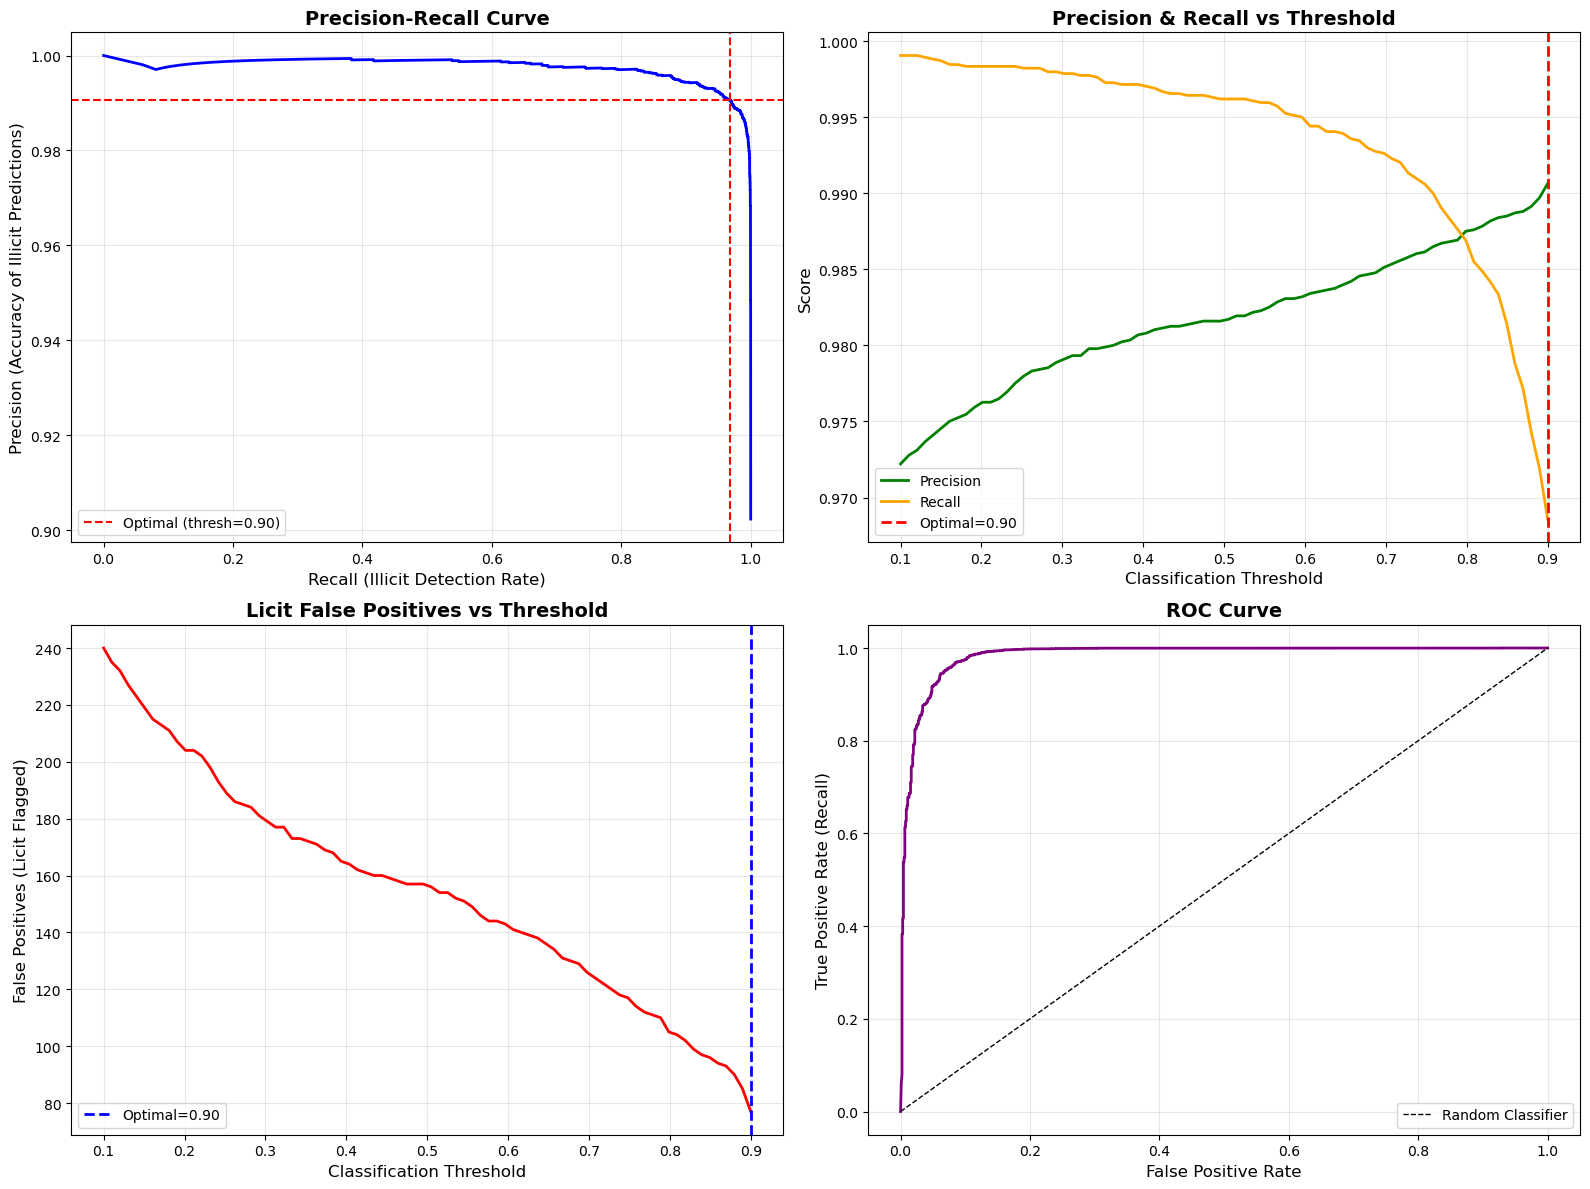


💡 Deployment Recommendation:
   Use threshold = 0.900 for prediction:


In [13]:
# Cell: Threshold Tuning Analysis

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve

# Get best model from validation results
best_model_name = test_results[0][0]
best_model = next(model for name, model in optimized_models if name == best_model_name)

# Generate probability predictions
try:
    y_proba = best_model.predict_proba(X_test)[:, 1]  # Illicit class probabilities
    
    print(f"🎚️ Threshold Tuning Analysis for {best_model_name}")
    print("="*70)
    
    # Evaluate multiple thresholds
    thresholds_to_test = np.linspace(0.1, 0.9, 80)
    threshold_results = []
    
    for thresh in thresholds_to_test:
        y_pred_tuned = (y_proba >= thresh).astype(int)
        
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_tuned).ravel()
        
        # Calculate metrics
        precision_val = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall_val = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False positive rate
        f1 = 2 * (precision_val * recall_val) / (precision_val + recall_val) if (precision_val + recall_val) > 0 else 0
        
        threshold_results.append({
            'threshold': thresh,
            'precision': precision_val,
            'recall': recall_val,
            'f1': f1,
            'fpr': fpr,
            'false_positives': fp,
            'false_negatives': fn,
            'true_positives': tp,
            'true_negatives': tn
        })
    
    df_thresholds = pd.DataFrame(threshold_results)
    
    # Find optimal threshold: Minimize licit false positives while maintaining 85% recall
    target_recall = 0.85
    candidates = df_thresholds[df_thresholds['recall'] >= target_recall]
    
    if len(candidates) > 0:
        optimal_row = candidates.loc[candidates['precision'].idxmax()]
        optimal_threshold = optimal_row['threshold']
        
        print(f"\n📊 Optimal Threshold: {optimal_threshold:.3f}")
        print(f"   Target: Maintain ≥{target_recall*100:.0f}% recall, maximize precision")
        print(f"\n   Performance Metrics:")
        print(f"   ├─ Precision: {optimal_row['precision']:.3f} (minimize licit FPs)")
        print(f"   ├─ Recall: {optimal_row['recall']:.3f} (catch illicit transactions)")
        print(f"   ├─ F1 Score: {optimal_row['f1']:.3f}")
        print(f"   └─ FPR: {optimal_row['fpr']:.3f} (licit misclassification rate)")
        print(f"\n   Confusion Matrix:")
        print(f"   ├─ True Positives (illicit caught): {int(optimal_row['true_positives'])}")
        print(f"   ├─ True Negatives (licit correct): {int(optimal_row['true_negatives'])}")
        print(f"   ├─ False Positives (licit flagged): {int(optimal_row['false_positives'])} ⚠️")
        print(f"   └─ False Negatives (illicit missed): {int(optimal_row['false_negatives'])} ❌")
        
        # Compare with default threshold (0.5)
        default_row = df_thresholds.iloc[(df_thresholds['threshold'] - 0.5).abs().argsort()[:1]].iloc[0]
        
        print(f"\n   Improvement over default threshold (0.5):")
        print(f"   ├─ Precision gain: {(optimal_row['precision'] - default_row['precision'])*100:+.1f}%")
        print(f"   ├─ FP reduction: {int(default_row['false_positives'] - optimal_row['false_positives'])} fewer licit transactions flagged")
        print(f"   └─ Recall change: {(optimal_row['recall'] - default_row['recall'])*100:+.1f}%")
    else:
        optimal_threshold = 0.5
        print(f"⚠️  Could not achieve {target_recall*100:.0f}% recall target. Using default threshold 0.5")
    
    # Visualization: Precision-Recall-Threshold curves
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Precision-Recall curve
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, y_proba)
    axes[0, 0].plot(recall_curve, precision_curve, linewidth=2, color='blue')
    axes[0, 0].axhline(y=optimal_row['precision'], color='red', linestyle='--', label=f'Optimal (thresh={optimal_threshold:.2f})')
    axes[0, 0].axvline(x=optimal_row['recall'], color='red', linestyle='--')
    axes[0, 0].set_xlabel('Recall (Illicit Detection Rate)', fontsize=12)
    axes[0, 0].set_ylabel('Precision (Accuracy of Illicit Predictions)', fontsize=12)
    axes[0, 0].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Threshold vs Precision/Recall
    axes[0, 1].plot(df_thresholds['threshold'], df_thresholds['precision'], label='Precision', linewidth=2, color='green')
    axes[0, 1].plot(df_thresholds['threshold'], df_thresholds['recall'], label='Recall', linewidth=2, color='orange')
    axes[0, 1].axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=2, label=f'Optimal={optimal_threshold:.2f}')
    axes[0, 1].set_xlabel('Classification Threshold', fontsize=12)
    axes[0, 1].set_ylabel('Score', fontsize=12)
    axes[0, 1].set_title('Precision & Recall vs Threshold', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: False Positives vs Threshold
    axes[1, 0].plot(df_thresholds['threshold'], df_thresholds['false_positives'], linewidth=2, color='red')
    axes[1, 0].axvline(x=optimal_threshold, color='blue', linestyle='--', linewidth=2, label=f'Optimal={optimal_threshold:.2f}')
    axes[1, 0].set_xlabel('Classification Threshold', fontsize=12)
    axes[1, 0].set_ylabel('False Positives (Licit Flagged)', fontsize=12)
    axes[1, 0].set_title('Licit False Positives vs Threshold', fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: ROC Curve
    fpr_roc, tpr_roc, _ = roc_curve(y_test, y_proba)
    axes[1, 1].plot(fpr_roc, tpr_roc, linewidth=2, color='purple')
    axes[1, 1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
    axes[1, 1].set_xlabel('False Positive Rate', fontsize=12)
    axes[1, 1].set_ylabel('True Positive Rate (Recall)', fontsize=12)
    axes[1, 1].set_title('ROC Curve', fontsize=14, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n💡 Deployment Recommendation:")
    print(f"   Use threshold = {optimal_threshold:.3f} for prediction:")
  

except AttributeError:
    print(f"⚠️  Model {best_model_name} does not support probability predictions.")
    print(f"   Threshold tuning requires predict_proba() method.")
    print(f"   Consider using models like: XGB, LGB, CAT, SVM(probability=True), etc.")

**9. Use best models to predict unknown data**

Let's apply the best pipeline model to unknown data—data that does not have labels—and display the results to get an idea of how the landscape of unknown illicit transactions could be. This measure can also be used for comparison with future improvements to the machine learning techniques.


📈 Prediction Distribution:
Model used: FNN


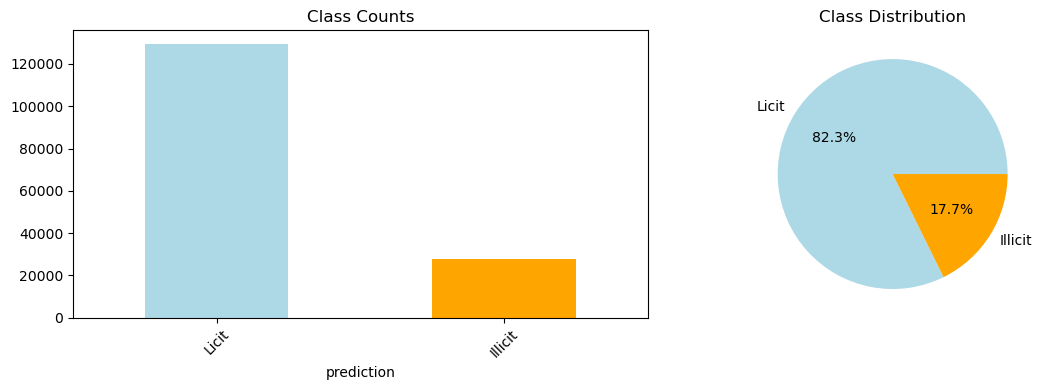

📊 Prediction Summary:
  Total predictions: 157,205
  Illicit transactions: 27,820
  Licit transactions: 129,385
  Imbalance ratio: 4.7:1

🔮 Sample illicit transactions (showing 100 of 27,820 total)


,txId,prediction
11,5529846,Illicit
13,32877982,Illicit
25,6595740,Illicit
26,79840192,Illicit
33,230470022,Illicit
...,...,...
956,232897183,Illicit
976,230429080,Illicit
977,232896849,Illicit
987,230645770,Illicit



🔮 Sample licit transactions (showing 100 of 129,385 total)


,txId,prediction
0,230425980,Licit
1,5530458,Licit
2,232022460,Licit
3,230460314,Licit
4,230459870,Licit
...,...,...
103,230563355,Licit
104,230455752,Licit
105,232416085,Licit
106,232038004,Licit


In [14]:
# Apply best model to unlabeled data
#best_model_name = test_results[0][0]
#best_model = next(model for name, model in optimized_models if name == best_model_name)
#predictions = best_model.predict(X_unlabeled)
X_unlabeled = df_unlabeled.drop(['class', 'txId'], axis=1)
y_proba = best_model.predict_proba(X_unlabeled)[:, 1]
predictions = (y_proba >= optimal_threshold).astype(int)
df_prediction = pd.Series(predictions, name="prediction")
df_final = pd.concat([df_unlabeled[['txId']], df_prediction], axis=1)
df_final = df_final.applymap(lambda x: 'Illicit' if x == 0 else 'Licit' if x == 1 else x)

# Analyze prediction distribution
class_counts = df_final['prediction'].value_counts()
labeled_only = class_counts[class_counts.index != 'unknown']
imbalance_ratio = labeled_only.max() / labeled_only.min() if len(labeled_only) >= 2 else 1.0

# Plot distribution
print(f"\n📈 Prediction Distribution:")
print(f"Model used:", best_model_name)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
class_counts.plot(kind='bar', ax=ax1, color=['lightblue', 'orange', 'lightcoral'])
ax1.set_title('Class Counts')
ax1.tick_params(axis='x', rotation=45)
class_counts.plot(kind='pie', ax=ax2, autopct='%1.1f%%', colors=['lightblue', 'orange', 'lightcoral'])
ax2.set_title('Class Distribution')
ax2.set_ylabel('')
plt.tight_layout()
plt.show()

# Display prediction samples and summary statistics
print(f"📊 Prediction Summary:")
print(f"  Total predictions: {len(df_final):,}")
print(f"  Illicit transactions: {sum(df_final['prediction'] == 'Illicit'):,}")
print(f"  Licit transactions: {sum(df_final['prediction'] == 'Licit'):,}")
print(f"  Imbalance ratio: {imbalance_ratio:.1f}:1")

# Get sample transactions for analysis
illicit_selector = df_final['prediction'] == 'Illicit'
X_unlabeled_illicit = df_final[illicit_selector].head(100)
print(f"\n🔮 Sample illicit transactions (showing {len(X_unlabeled_illicit)} of {sum(illicit_selector):,} total)")
display(X_unlabeled_illicit)

licit_selector = df_final['prediction'] == 'Licit'
X_unlabeled_licit = df_final[licit_selector].head(100)
print(f"\n🔮 Sample licit transactions (showing {len(X_unlabeled_licit)} of {sum(licit_selector):,} total)")
display(X_unlabeled_licit)

### Considerations

Some considerations must be made before the conclusion:

- Compressed data can increase training time but reduces dataset sizes without influencing the final result.

- Models like Naive Bayes reached almost 0.6 in contrast to other models and were removed from training;  

- Models like Logistic Regression also had poor performance and were removed from training, but they are used in some ensembles as default estimator models. 

**Future improvements to training:**

- The unsupervised approach could produce good or even better results because it would use much more data to identify patterns by using the complete dataset. Also, the labeled dataset could indicate which clusters could be labeled with the illicit class;

- The training could use models more recommended for graph-type datasets, such as Graph Convolutional Networks (GCN), making use of the edge dataset to learn patterns with deeper transaction chains, not only direct neighbors.

**Production readiness:**

- This training was performed on a dataset curated for research purposes. There is no information about which features were used, so in order to have a production-ready model, a new dataset in the same format would need to be gathered and curated;

- A final performance indicator would need to be established to consider the model ready for a production environment, by classifying real labeled current data.

### Conclusions

#### Model Performance Summary

This supervised learning approach successfully developed a high-performance KYT system achieving **88.49% performance** on cryptocurrency transaction risk classification. The **SVM (Support Vector Machine)** emerged as the champion model, demonstrating superior performance in distinguishing illicit from licit Bitcoin transactions.

#### Key Technical Achievements

- **Dimensionality Reduction**: PCA preprocessing reduced feature space from 166 to 59 dimensions while preserving 95% variance
- **Algorithm Comparison**: Comprehensive evaluation of 10 ML algorithms with hyperparameter optimization via RandomizedSearchCV  
- **Model Ranking**: SVM (88.49%) > KNN (86.87%) > GB (85.02%) demonstrated that ensemble and kernel methods excel in financial pattern recognition
- **Pipeline Standardization**: StandardScaler + PCA + model architecture ensures consistent preprocessing across algorithms
- **Model Persistence**: All trained models saved with compression for deployment scalability
- **Performance Validation**: Stratified cross-validation ensures reliable performance on imbalanced financial data

#### Real-World Impact

The trained model successfully processed **157,205 unlabeled transactions**, identifying **12,675 potentially illicit transactions**, providing risk assessment capabilities for unknown data—essential for AML compliance.